# Load in the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
data = pd.read_csv('/Users/william/Downloads/cleaned_data.csv')
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.3, random_state=95)

In [ ]:
#Helper Function: accuracy
def accuracy(y_test, y_pred):
    a=0
    for i in len(y_test):
        if y_test[i]==y_pred[i]:
            a+=1
    return a/len(y_test)

# Data pre-processing

In [ ]:
# We need only numerical variables for this model
# Then, we replace the value 'Yes' of the outcome by 1, and 'No' by 0

y_train = data_train['cumulative_outcome']
y_train = [1 if x=='Yes' else 0 for x in y_train]
x_train = data_train[data_train.columns[1:]]
x_train = x_train.drop(columns = ['cumulative_outcome'],axis=1)
xd = pd.get_dummies(x_train)

In [ ]:
#We replace the Nan values by the value that appears the most often in the column

for column in xd.columns:
    xd[column]=xd[column].fillna(xd[column].mode()[0])

# Prediction: Ridge Classifier

## First model

In [ ]:
from sklearn.linear_model import RidgeClassifier

alpha_max = 10**5
rr = RidgeClassifier(alpha=alpha_max, random_state=88)
rr.fit(xd, y_train)

RidgeClassifier(alpha=100000, random_state=88)

## Evolution of the value of the coefficients

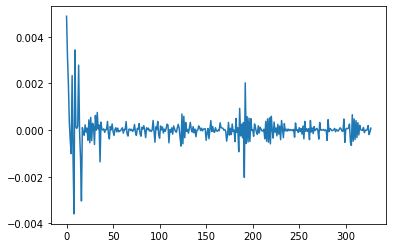

0.0048814152535055135


In [ ]:
plt.plot(rr.coef_[0])
plt.show()
print(max(abs(rr.coef_[0])))

In [ ]:
rr.coef_[0][1]

0.0031545544766037755

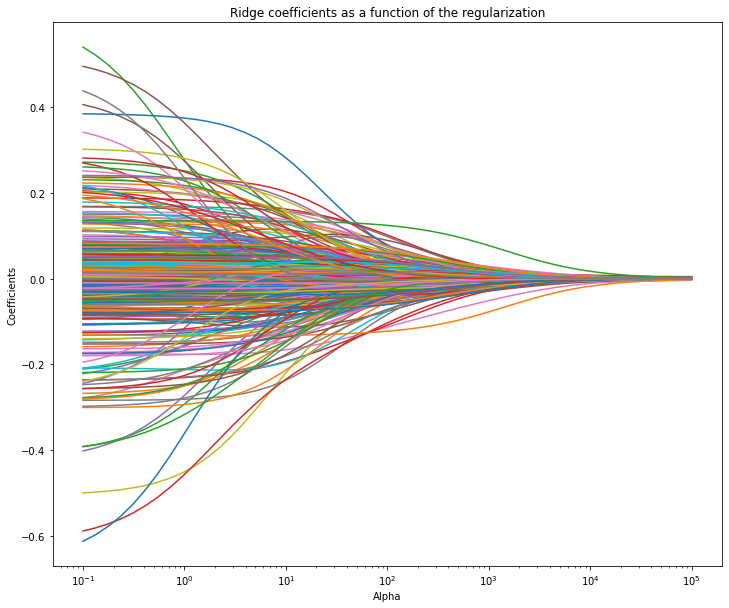

In [ ]:
alpha_grid = np.logspace(-1, 5, num=50, base=10)
coefs = []
for a in alpha_grid:
    rr = RidgeClassifier(alpha=a, fit_intercept=False, random_state=88)
    rr.fit(xd, y_train)
    coefs.append(rr.coef_[0])

plt.figure(figsize=(12, 10))
ax = plt.gca()
ax.plot(alpha_grid, coefs)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.show()

## Second Model: Cross-Validation to tune the Ridge parameter

In [ ]:
from sklearn.model_selection import GridSearchCV


alpha_grid = {'alpha': np.logspace(-1, 5, num=50, base=10)}

rr = RidgeClassifier(random_state=88)
rr_cv = GridSearchCV(rr, alpha_grid, scoring='accuracy', cv=10, verbose = 4)
rr_cv.fit(xd, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END .....................................alpha=0.1; total time=   0.1s
[CV 2/10] END .....................................alpha=0.1; total time=   0.0s
[CV 3/10] END .....................................alpha=0.1; total time=   0.0s
[CV 4/10] END .....................................alpha=0.1; total time=   0.0s
[CV 5/10] END .....................................alpha=0.1; total time=   0.0s
[CV 6/10] END .....................................alpha=0.1; total time=   0.0s
[CV 7/10] END .....................................alpha=0.1; total time=   0.0s
[CV 8/10] END .....................................alpha=0.1; total time=   0.0s
[CV 9/10] END .....................................alpha=0.1; total time=   0.0s
[CV 10/10] END ....................................alpha=0.1; total time=   0.0s
[CV 1/10] END .....................alpha=0.13257113655901093; total time=   0.1s
[CV 2/10] END .....................alpha=0.132

GridSearchCV(cv=10, estimator=RidgeClassifier(random_state=88),
             param_grid={'alpha': array([1.00000000e-01, 1.32571137e-01, 1.75751062e-01, 2.32995181e-01,
       3.08884360e-01, 4.09491506e-01, 5.42867544e-01, 7.19685673e-01,
       9.54095476e-01, 1.26485522e+00, 1.67683294e+00, 2.22299648e+00,
       2.94705170e+00, 3.90693994e+00, 5.17947468e+00, 6.86648845e+00,
       9.10298178e+00, 1.2067...
       2.68269580e+02, 3.55648031e+02, 4.71486636e+02, 6.25055193e+02,
       8.28642773e+02, 1.09854114e+03, 1.45634848e+03, 1.93069773e+03,
       2.55954792e+03, 3.39322177e+03, 4.49843267e+03, 5.96362332e+03,
       7.90604321e+03, 1.04811313e+04, 1.38949549e+04, 1.84206997e+04,
       2.44205309e+04, 3.23745754e+04, 4.29193426e+04, 5.68986603e+04,
       7.54312006e+04, 1.00000000e+05])},
             scoring='accuracy', verbose=4)

In [ ]:
def one_standard_error_rule(model, results, param_grid, n_splits):
    
    #assert neg_mean_squared_error == True # function is defined specifically for neg_mean_squared_error
    
    #find model with minimum error, then select the simplest model
    #whose mean falls within 1 standard deviation of the minimum
    
    range_x = param_grid # results['param_'+list(param_grid.keys())[0]].data
    std_vs_x  = pd.Series(results['std_test_score'], index = range_x)
    sem_vs_x  = std_vs_x/np.sqrt(n_splits)
    
    mean_vs_x = pd.Series(results['mean_test_score'], index = range_x)        
    mean_vs_x = mean_vs_x*(-1)
    
    x_min = mean_vs_x.idxmin()
    sem = sem_vs_x[x_min]
    

    if (model=='pcr'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.min()
    elif (model=='ridge') | (model=='lasso'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.max()
        
    #x_1se_idx = int(np.argwhere(range_x == x_1se)[0])
    
    return x_min, x_1se

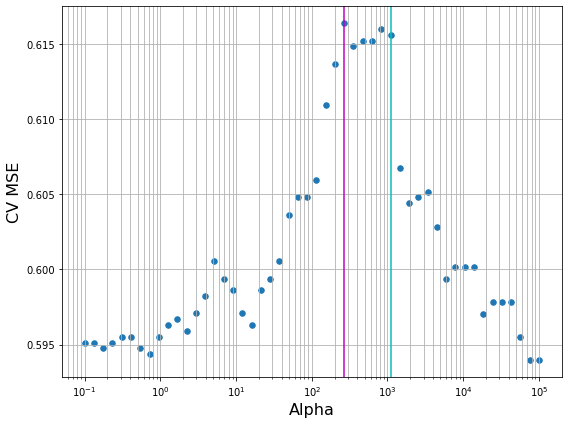

In [ ]:
range_alpha = rr_cv.cv_results_['param_alpha'].data
accuracy_scores = rr_cv.cv_results_['mean_test_score']
x_min, x_1se = one_standard_error_rule(model='ridge',
                                       results=rr_cv.cv_results_,
                                       param_grid=range_alpha,
                                       n_splits=10,
                                       )
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('CV MSE', fontsize=16)
plt.scatter(range_alpha, accuracy_scores, s=30)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [ ]:
print('Alpha one standard error rule:', x_1se)

Alpha one standard error rule: 1098.5411419875572


### Fitting of the model with the best parameter

In [ ]:
rr_cv = GridSearchCV(rr, {'alpha': [x_1se]}, scoring='accuracy', cv=10)
rr_cv.fit(xd, y_train)

GridSearchCV(cv=10, estimator=RidgeClassifier(random_state=88),
             param_grid={'alpha': [1098.5411419875572]}, scoring='accuracy')

In [ ]:
# We need only numerical variables for this model
# Then, we replace the value 'Yes' of the outcome by 1, and 'No' by 0

y_test = data_test['cumulative_outcome']
y_test = [1 if x=='Yes' else 0 for x in y_test]
x_test = data_test[data_test.columns[1:]]
x_test = x_test.drop(columns = ['cumulative_outcome'],axis=1)
xd_test = pd.get_dummies(x_test)

#treatment of missing data: we put the most common observation in place of the missing data
for column in xd_test.columns:
    xd_test[column]=xd_test[column].fillna(xd_test[column].mode()[0])

In [ ]:
from sklearn.metrics import accuracy_score


print('Accuracy:', round(accuracy_score(y_test, rr_cv.predict(xd_test)), 5))

Accuracy: 0.61926


In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, rr_cv.predict(xd_test))

print(fpr,tpr)


[0.         0.18449612 1.        ] [0.         0.34763948 1.        ]


In [ ]:
def create_polynomial_features(df, n_degree):

    new_df = None
    
    for i in range(2, n_degree+1):
        
        tmp = df.pow(i)
        
        affix = '_pow_'+str(i)
        tmp.columns = list(map(lambda x: x + affix, df.columns))
        
        if new_df is not None:
            new_df = pd.concat([new_df, tmp], axis=1)
        else:
            new_df = tmp
    
    return new_df

In [ ]:
n_degree = 3

X_train_poly = pd.concat([xd, create_polynomial_features(xd[xd.columns], n_degree)], axis=1)
X_test_poly = pd.concat([xd_test, create_polynomial_features(xd[xd.columns], n_degree)], axis=1)


print(X_train_poly.shape, X_test_poly.shape)

(2591, 984) (3702, 984)


In [ ]:
rr_cv.fit(X_train_poly , y_train)

/Users/william/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.21138e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/william/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.19124e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/william/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.95134e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/william/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.20616e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/william/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: 

GridSearchCV(cv=10, estimator=RidgeClassifier(random_state=88),
             param_grid={'alpha': [1098.5411419875572]}, scoring='accuracy')

In [ ]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(penalty='l2')

In [ ]:
LogReg.fit(xd, y_train)

/Users/william/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
print('Accuracy:', round(accuracy_score(y_test, LogReg.predict(xd_test)), 5))

Accuracy: 0.58596
